In [26]:
# Importacion de paquetes necesarios
import pandas as pd
import numpy as np
import csv
import os
from pathlib import Path
import datetime
from datetime import date
import random


from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials
from hyperopt import Trials
from timeit import default_timer as timer
import ml_metrics   

pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


#### Exportamos el dataset limpio

In [27]:
df = pd.read_csv("../data_predictive/clean_sold.csv", index_col=0)
# Splitting Features and Label


#### Seteamos la Seed

In [28]:
# Apparently you may use different seed values at each stage
seed_value= 0
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)
# 4. Set the `tensorflow` pseudo-random generator at a fixed value

#### En este experimento vamos a probar Subsamplear la clase mayoritaria


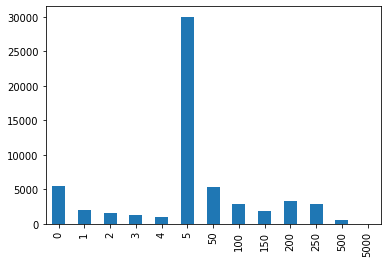

In [8]:
df["sold_quantity"].value_counts().sort_index().plot.bar()


In [9]:
sold_prop = df["sold_quantity"].value_counts()/len(df)
print("Proporción por clase")
print(sold_prop)

Proporción por clase
5       0.517713
0       0.094993
50      0.091236
200     0.055879
250     0.049314
100     0.048435
1       0.033772
150     0.032411
2       0.027414
3       0.021383
4       0.017145
500     0.010149
5000    0.000155
Name: sold_quantity, dtype: float64


In [10]:
subs_df =pd.DataFrame()
for level,prop in sold_prop.items():
    subs_df = pd.concat([subs_df , df[df["sold_quantity"] == level ].sample(frac =( 1 if prop<0.10 else 0.1 ))])

### Las Clases estan mucho más balanceadas por el coste de perder algunos registros del dataset

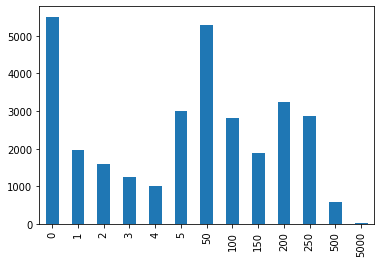

In [11]:
subs_df["sold_quantity"].value_counts().sort_index().plot.bar()


In [12]:
sold_prop = subs_df["sold_quantity"].value_counts()/len(subs_df)
print("Proporción por clase")
print(sold_prop)

Proporción por clase
0       0.177867
50      0.170834
200     0.104630
5       0.096951
250     0.092337
100     0.090692
1       0.063236
150     0.060687
2       0.051331
3       0.040039
4       0.032102
500     0.019003
5000    0.000290
Name: sold_quantity, dtype: float64


#### Partición al 70% del dataset subsampleada compuesto con 40000 registros

In [15]:
y = df["sold_quantity"]
X = df.drop(["sold_quantity"],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,random_state = seed_value)

In [16]:
exp_name = 'test_exp'
folder = 'Resultados/' + exp_name
my_file = Path(folder)
if os.path.exists(my_file):
    print('already exists')
else:
    os.makedirs(folder)

out_file = folder + '/subxgb_results.csv'
of_connection = open(out_file, 'w')

In [ ]:
#### Espacio de busqueda de los hiperparametros del XGB

In [17]:
space = {
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.7, 0.01),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01),
    'n_estimators' : hp.choice('n_estimators', range(50,1000,50)),
    'alpha' : hp.choice('alpha', range(0,20)),
    'gamma' : hp.quniform('gamma', 0, 0.5, 0.01),
    'max_depth' : hp.choice('max_depth', range(5, 300, 5)),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01)
    }


In [21]:
#Objective function that hyperopt will minimize

def objective(params):
    start = timer()
    print ('Params testing: ', params)
    print ('\n ')

    model = XGBClassifier(params)
    #predict the test set 
#     predictions = model.predict(X_test)
#     acc = accuracy_score(y_test, predictions)
    skf = StratifiedKFold(n_splits=3, shuffle=True,random_state = seed_value)
    fscore = cross_val_score(estimator = model, X = X_train, y = y_train, cv = skf,scoring="f1_weighted")
    CrossValMean = fscore.mean()
    print("Final CrossValMean: ", CrossValMean)
    return{'loss':1-CrossValMean, 'status': STATUS_OK }
    
    score = 1-CrossValMean
    run_time = timer() - start
    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([CrossValMean, params, score, run_time])
    of_connection.close()
    print('Test accuracy:', CrossValMean)
 
    return {'loss': score,  'status': STATUS_OK, 'train_time': run_time,}



In [22]:
tpe_algorithm = tpe.suggest
bayes_trials = Trials()
trials = Trials()

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = 5, trials = bayes_trials,
            verbose = 1, rstate= np.random.RandomState(50))


Params testing:                                                                                                        
{'alpha': 6, 'colsample_bytree': 0.38, 'gamma': 0.4, 'learning_rate': 0.42, 'max_depth': 55, 'n_estimators': 700, 'subsample': 1.0}
Final CrossValMean:                                                                                                    
0.7323192765513019                                                                                                     
Params testing:                                                                                                        
{'alpha': 15, 'colsample_bytree': 0.15, 'gamma': 0.45, 'learning_rate': 0.36, 'max_depth': 275, 'n_estimators': 500, 'subsample': 0.87}
Final CrossValMean:                                                                                                    
0.7323192765513019                                                                                                     
Params testi

#### Los mejores hiperparametros:

In [29]:
best_subxgb= {'alpha': 13, 'colsample_bytree': 0.46, 'gamma': 0.14, 'learning_rate': 0.13, 'max_depth': 90, 'n_estimators': 500, 'subsample': 0.47000000000000003}